In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
import sklearn
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense
import tsaug

In [12]:
windows = np.load('windows.npy')
labels = np.load('labels.npy')

In [13]:
X_train, X_val, y_train, y_val = train_test_split(windows, labels, test_size=0.2, random_state=42, stratify=labels)

In [23]:
print(X_train.shape)

(1151, 3, 2)


In [14]:
num_classes = 8

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(windows.shape[1], windows.shape[2])),  # (window_size, 3)
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # 8 classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # since y_train is integer labels (0–7)
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,832 (85.28 KB)

 Trainable params: 21,832 (85.28 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    shuffle=True  # optional but recommended
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4022 - loss: 1.8466 - val_accuracy: 0.7743 - val_loss: 0.9473
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7743 - loss: 0.8322 - val_accuracy: 0.7778 - val_loss: 0.6493
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7964 - loss: 0.5924 - val_accuracy: 0.8229 - val_loss: 0.5440
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8288 - loss: 0.5329 - val_accuracy: 0.8542 - val_loss: 0.4509
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8614 - loss: 0.4207 - val_accuracy: 0.9062 - val_loss: 0.3747
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9138 - loss: 0.3386 - val_accuracy: 0.8924 - val_loss: 0.3142
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9092 - loss: 0.3011 - val_accuracy: 0.9097 - val_loss: 0.2664
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9244 - loss: 0.2541 - val_accuracy: 0.9097 - val_l

In [18]:
test_loss, test_acc = model.evaluate(X_val, y_val, batch_size=64)
print(f"Validation accuracy: {test_acc:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9593 - loss: 0.1253
Validation accuracy: 0.97


In [19]:
preds = model.predict(X_val)  # shape = (num_samples, 8)
predicted_labels = preds.argmax(axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


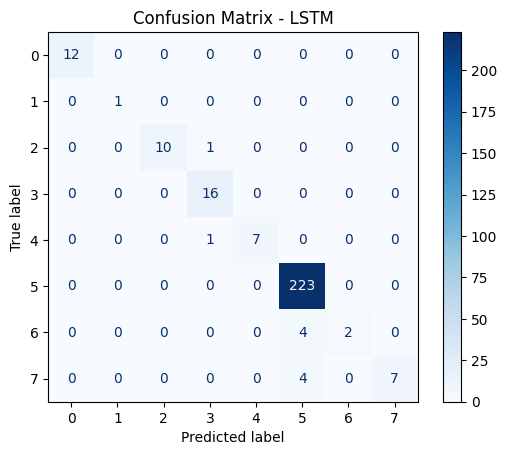

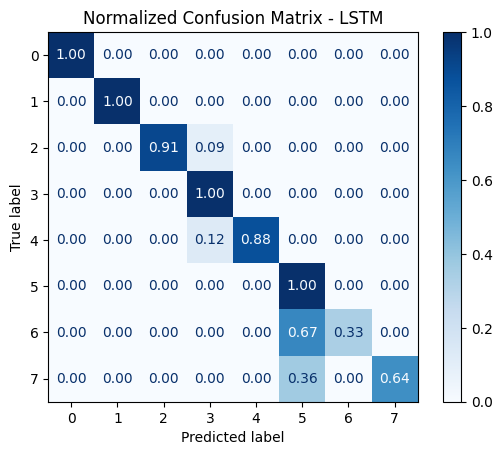

In [20]:
cm = confusion_matrix(y_val, predicted_labels, labels=np.arange(num_classes))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LSTM")
plt.show()

cm = confusion_matrix(y_val, predicted_labels, labels=np.arange(num_classes))

row_sum = cm.sum(axis=1, keepdims=True)
row_sum[row_sum == 0] = 1

cm_normalized = cm.astype('float') / row_sum

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=np.arange(num_classes))
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # shows values with 2 decimal places
plt.title("Normalized Confusion Matrix - LSTM")
plt.show()

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_enable_resource_variables = True
converter._experimental_lower_tensor_list_ops = False

# Allow unsupported ops fallback (needed for some LSTM internals)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS,
]
tflite_model = converter.convert()
open("model_LSTM.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\jonat\AppData\Local\Temp\tmp8uff3b5f\assets


INFO:tensorflow:Assets written to: C:\Users\jonat\AppData\Local\Temp\tmp8uff3b5f\assets


Saved artifact at 'C:\Users\jonat\AppData\Local\Temp\tmp8uff3b5f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 2), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1811331549520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392514000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392515920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392514192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392513040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811358085584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392516688: TensorSpec(shape=(), dtype=tf.resource, name=None)


98808

In [22]:
model.export("model_LSTM")

INFO:tensorflow:Assets written to: model_LSTM\assets


INFO:tensorflow:Assets written to: model_LSTM\assets


Saved artifact at 'model_LSTM'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 2), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1811331549520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392514000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392515920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392514192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392513040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811358085584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1811392516688: TensorSpec(shape=(), dtype=tf.resource, name=None)
